**Marco Pezzella**

 You can send your homework on the marc.pezzman@gmail.com email address and share it on github.

# Homework: predicting C$_2$H$_2$ and C$_2$ energy levels

## C$_2$H$_2$

 From the [Marvel website](http://kkrk.chem.elte.hu/marvelonline/data_files/C2H2_energylevels_2019-03-20.txt) download the moelcule's states file. The file contains 7 vibrational quantum numbers (v1, v2, v3, v4, v5, l4, l5), two rotational numbers (k, J), and some symmetry numbers (ef, op, u/g and symm). Remove the states with -1, as they indicate unknown levels.


| v1 | v2 | v3 | v4 | l4 | v5 | l5 | k | J | ef | op    | Energy     | Unc      | NumTrans | u/g | Sym            |
|----|----|----|----|----|----|----|---|---|----|-------|------------|----------|----------|-----|----------------|
| 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0 | 1 | e  | ortho | 2.353286   | 0.000000 | 204      | g   | sigma_g_plus  |
| 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0 | 3 | e  | ortho | 14.119512  | 0.000041 | 289      | g   | sigma_g_plus  |



| Column          | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `v1, v2, v3, v4, l4, v5, l5` | Quantum numbers representing vibrational or rotational states.       |
| `k`              | Likely a rotational quantum number.                                         |
| `J`              | Total angular momentum quantum number.                                      |
| `ef`             | Parity (e or f) or electronic state.                                        |
| `op`             | Symmetry or spin designation (e.g., ortho/para).                            |
| `Energy`         | Energy of the state in arbitrary units (often cm⁻¹ or eV).                  |
| `Unc`            | Uncertainty in the energy value.                                            |
| `NumTrans`       | Number of transitions involving this state.                                 |
| `u/g`            | Symmetry under inversion (ungerade = u, gerade = g).                        |
| `Sym`            | Full symmetry label, such as irreducible representation of the state.       |



### What to do:
1. Build two models of your choice for predicting the states, using the vibrational and rotational numbers. Try to reach the chemical accuracy (~1 kcal/mol or ~0.05 eV).
2. Perform the same task adding the symmetry quantum numbers. How do the results change?
3. Is it possible to clusterise the states based on their symmetries?

[MARVEL website for C2H2](http://kkrk.chem.elte.hu/marvelonline/getdata.php?molid=8&isotopid=21)


Remove the states with -1, as they indicate unknown levels.

In [3]:
input_file = "C2H2.dat"
output_file = "C2H2_filtered.dat"

# Read the file and process lines
with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    # Write header to output file
    header = infile.readline()
    outfile.write(header)

    # Process each line
    for line in infile:
        # Split the line into columns
        columns = line.split()

        # Check if any of the first 7 columns contain a negative value
        if all(float(col) >= 0 for col in columns[:7]):
            # Write valid lines to the output file
            outfile.write(line)

print(f"Filtered data written to {output_file}")

Filtered data written to C2H2_filtered.dat


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

Mean Squared Error: 0.04 eV
Best parameters found: {'alpha': 0.1, 'gamma': 0.01}
Model meets chemical accuracy!


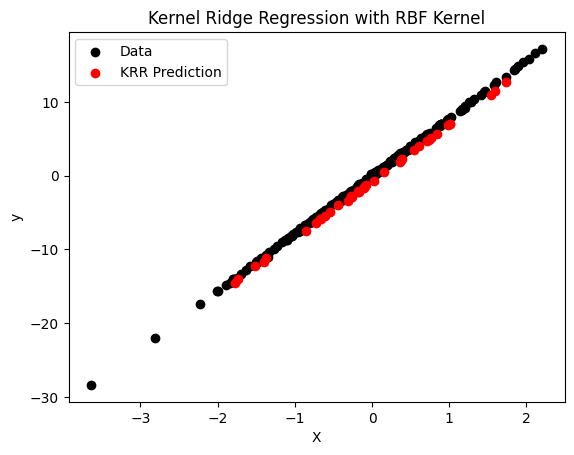

In [195]:
# Kernel Ridge Regression

# Load the data
data = pd.read_csv("C2H2_filtered.dat", sep='\s+')

# Define features (vibrational and rotational numbers) and target (Energy)
X = data[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J']]
y = data['Energy']

# Train-test split
X, y = make_regression(n_samples=200, n_features=1, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
krr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
krr.fit(X_train, y_train)

# Predict and evaluate
y_pred = krr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f} eV')

# Found the best parameters to have the expectred accuracy
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0],
}
grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

# Check accuracy
if mse < 0.05:
    print("Model meets chemical accuracy!")

plt.scatter(X, y, color='black', label='Data')
plt.scatter(X_test, y_test, color='red', label='KRR Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Ridge Regression with RBF Kernel')
plt.show()

Mean Squared Error: 0.03 eV
Best parameters found: {'alpha': 0.1, 'gamma': 0.01}
Model meets chemical accuracy!


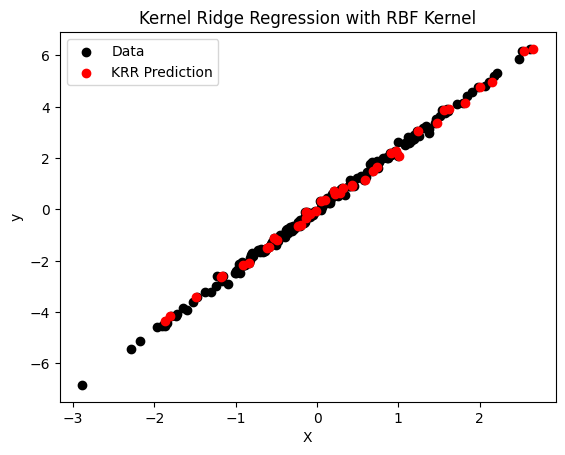

In [119]:
# Kernel Ridge Regression with Symmetry Quantum Numbers

# Load the data
data = pd.read_csv("C2H2_filtered.dat", sep='\s+')

# Encode symmetry-related features using LabelEncoder
symmetry_features = ['ef', 'op', 'u/g']
label_encoders = {col: LabelEncoder() for col in symmetry_features}
for col in label_encoders:
    data[col] = label_encoders[col].fit_transform(data[col])

# Extract features (vibrational, rotational, and symmetry numbers) and target (Energy)
X = data[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J', 'ef', 'op', 'u/g', 'Sym']]
y = data['Energy']

# Train-test split
X, y = make_regression(n_samples=200, n_features=1, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
krr = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
krr.fit(X_train, y_train)

# Predict and evaluate
y_pred = krr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f} eV')

# Found the best parameters to have the expectred accuracy
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0, 10.0],
}
grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

# Check accuracy
if mse < 0.05:
    print("Model meets chemical accuracy!")

plt.scatter(X, y, color='black', label='Data')
plt.scatter(X_test, y_test, color='red', label='KRR Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Kernel Ridge Regression with RBF Kernel')
plt.show()

In [159]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate

In [170]:
# Random Forest

# Load the data
data = pd.read_csv("C2H2_filtered.dat", sep='\s+')

# Shuffle the datas
data = data.sample(frac=1)

# Define features (vibrational and rotational numbers) and target (Energy)
X = data[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J']]
y = data['Energy']

# Evaluate the model with different numbers of estimators
for i in range(50, 150, 10):  # Evaluate with varying numbers of trees
    Random_Forest_model = RandomForestRegressor(n_estimators=i, criterion="squared_error")
    results = cross_validate(Random_Forest_model, X, y, cv=10, scoring='r2')  # Use R² as a metric for regression
    accuracy = results['test_score']
    print('The R² score is: ', sum(accuracy) / len(accuracy) * 100, '%')
    if 100 - (sum(accuracy) / len(accuracy) * 100) < 0.05:  # Check accuracy
      print("Model meets chemical accuracy!")
    print(f"   ")

The R² score is:  99.94639032493957 %
   
The R² score is:  99.95169832657916 %
Model meets chemical accuracy!
   
The R² score is:  99.95143885611377 %
Model meets chemical accuracy!
   
The R² score is:  99.95096448377268 %
Model meets chemical accuracy!
   
The R² score is:  99.9497461402093 %
   
The R² score is:  99.95126882084455 %
Model meets chemical accuracy!
   
The R² score is:  99.95048054609255 %
Model meets chemical accuracy!
   
The R² score is:  99.95229606283387 %
Model meets chemical accuracy!
   
The R² score is:  99.95211944064447 %
Model meets chemical accuracy!
   
The R² score is:  99.95112647482516 %
Model meets chemical accuracy!
   


In [152]:
# Random Forest with Symmetry Quantum Numbers

# Load the dataset
data = pd.read_csv("C2H2_filtered.dat", sep='\s+')

# Shuffle the dataset
data = data.sample(frac=1)

# Encode symmetry-related features using LabelEncoder
symmetry_features = ['ef', 'op', 'u/g', 'Sym']  # Columns to encode
label_encoders = {col: LabelEncoder() for col in symmetry_features}
for col in label_encoders:
    data[col] = label_encoders[col].fit_transform(data[col])

# Extract features (vibrational, rotational, and symmetry numbers) and target (Energy)
X = data[['v1', 'v2', 'v3', 'v4', 'l4', 'v5', 'l5', 'k', 'J', 'ef', 'op', 'u/g', 'Sym']]
y = data['Energy']

# Evaluate the model with different numbers of estimators
for i in range(200, 1000, 200):  # Evaluate with varying numbers of trees
    Random_Forest_model = RandomForestRegressor(n_estimators=i, criterion="squared_error")
    results = cross_validate(Random_Forest_model, X, y, cv=10, scoring='r2')  # Use R² as a metric for regression
    accuracy = results['test_score']
    print('The R² score is: ', sum(accuracy) / len(accuracy) * 100, '%')
    if 100 - (sum(accuracy) / len(accuracy) * 100) < 0.05:  # Check accuracy
      print("Model meets chemical accuracy!")
    print(f"   ")

The R² score is:  99.9484582763478 %
   
The R² score is:  99.94906281406573 %
   
The R² score is:  99.94956583914721 %
   
The R² score is:  99.95000055318573 %
Model meets chemical accuracy!
   


## Question 2
How do the results change?

By adding symmetry quantum numbers, the accuracy driven by the Mean Squared Error (MSE) is better (MSE = 0.03 by taking in account the symmetry against MSE = 0.04 without). However, the model need more estimators to improve accuracy. 100 estimators without taking in account the symmetry against 800 estimators with.

## Question 3
Is it possible to clusterise the states based on their symmetries?

Clustering states based on their symmetries is indeed a feasible approach. For example, the vibrational and rotational quantum numbers, which describe the vibrational and rotational modes of a system, can be coupled with the system's symmetry properties. This coupling allows for grouping states that share similar characteristics. Energy levels provide an additional numerical feature for clustering, as states with similar symmetries often lie within specific energy ranges. Including the symmetry quantum numbers should result in more accurate clustering, as they directly distinguish states with different symmetry properties. In conclusion, symmetry properties make clustering both feasible and meaningful, as they are fundamental to the organization of molecular states. We will apply this approach in the second exercise, where we will separate each state to observe the different features of individual states.

Reference:
Zhu, Y. F., Allman, S. L., Phillips, R. C., Garrett, W. R., & Chen, C. H. (1994). Rydberg states of acetylene clusters $\text{CH}_2$ and $\text{CH}_3$
resolved by two-photon resonant ionization spectroscopy. Chemical Physics Letters, 224(1-2), 7-15. https://doi.org/10.1016/0009-2614(94)05298-X



## C$_2$
From the [ExoMol website](https:www.exomol.com), download the states file for [$^{12}$C$_2$](https://exomol.com/db/C2/12C2/8states/12C2__8states.states.bz2) and [$^{13}$C$_2$](https://exomol.com/db/C2/13C2/8states/13C2__8states.states.bz2).



| Index | Energy      | $g_\mathrm{tot}$  | $J$ | Unc   | $\tau$        | $g$    | $\pm$ | ef | State         | v | $\Lambda$ | $\Sigma$ | $\Omega$ | F$_{sym}$ | idx | src    | E$_{calc}$    |
|-------|-------------|-----|-----|----------|------------|--------|-----|----|---------------|-----|-----|-----|-----|----------|-----|--------|-------------|
| 1     | 0.000000    | 1   | 0   | 0.009813 | Inf        | 0.0000 | +   | e  | X(1SIGMA+g)   | 0   | 0   | 0   | 0   | F1       | 0   | d      | 0.000000    |
| 2     | 1827.487599 | 1   | 0   | 0.000900 | 1.7058E+03 | 0.0000 | +   | e  | X(1SIGMA+g)   | 1   | 0   | 0   | 0   | F1       | 0   | m      | 1827.480518 |


"**NB:** The ExoMol states file is in the following format. (Old format, see the [most recent paper](https://doi.org/10.48550/arXiv.2406.06347) for the formatting of more recent data.
| Field                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `i`                    | State ID                                                                    |
| $\tilde{E}$            | Recommended state energy in $\\mathrm{cm^{-1}}$                            |
| $g_\mathrm{tot}$       | State degeneracy                                                            |
| $J$                    | Total angular momentum quantum number, $J$ or $F$ (integer/half-integer)    |
| Unc                    | Uncertainty in the state energy in $\\mathrm{cm^{-1}}$                       |
| $\tau$                 | State lifetime (aggregated radiative and predissociative lifetimes) in s    |
| $g$                  | Landé $g$-factor (optional)                                                 |
| QN                   | State quantum numbers, may be several columns (optional)                    |


### What to do
1. Predict the molecular constants for the X(1SIGMA+g) and the b(3SIGMA-g). Compare the constants obtained for 12C2 with the ones available from the [NIST database](https://webbook.nist.gov/cgi/inchi?ID=C12070154&Mask=1000#Diatomic).
2. Use  a Kernel model to reproduce the [heat capacity](https://exomol.com/db/C2/12C2/8states/12C2__8states.cp)  and [partition function](https://exomol.com/db/C2/12C2/8states/12C2__8states.pf) of $^{12}$C$_2$.

[ExoMol website for C2.](https://exomol.com/data/molecules/C2/12C2/8states/)


In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,root_mean_squared_error

In [179]:
# Predict the molecular constants for the state X(1SIGMA+g) for 12C2

# Open the file in read mode
with open('12C2__8states.states', 'r') as file:
    # Read each line in the file, splitting it into individual elements
    inputfile = [line.split() for line in file]

# Convert the data into a pandas DataFrame for easy manipulation
df = pd.DataFrame(inputfile)
df.index = df.index + 1  # Adjust the DataFrame index to start from 1
df.columns = ["Index", "Energy", "gtot", "J", "unc", "τ", "g", "+/−", "ef", "State", "v", "Λ", "Σ", "Ω", "Fsym", "idx", "src", "Ecalc"]

# Filter rows where the "State" column equals "X(1SIGMA+g)"
C2_X = df[df["State"] == "X(1SIGMA+g)"]

# Extract the vibrational quantum number (v) and rotational quantum number (J) as features (X) and the Energy column as the target variable (Y)
X = C2_X[['v', 'J']].values
Y = C2_X['Energy'].values

# Perform machine learning and regression tasks (Random Forest Regressor model)
for i in range(1, 5):
    # Train the model on the training data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

    rf_model = RandomForestRegressor(n_estimators=100, criterion="squared_error", oob_score=True, random_state=10)
    rf_model.fit(X_train, Y_train)

    y_pred_rf_est = rf_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_train)

    X_test = X_test.astype(float)  # Ensure X_test is in float type
    X_transformed = np.column_stack([
        (X_test[:, 0] + 0.5),
        (X_test[:, 0] + 0.5) ** 2,
        (X_test[:, 1] * (X_test[:, 1] + 1) * (X_test[:, 0] + 0.5)),  # (a3 + a4 * (x1 + 0.5)) * x2 * (x2 + 1)
        (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2  # a5 * (x2^2) * (x2 + 1)^2
    ])

    # Fit a linear regression model
    linear_model = LinearRegression()
    linear_model.fit(X_transformed, y_pred_rf_est)
    predicted_coefficients = linear_model.coef_

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, y_pred_rf_est)
    rmse = root_mean_squared_error(Y_test, y_pred_rf_est)
    r2 = r2_score(Y_test, y_pred_rf_est)

    print("=== Estimation Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")

    print("=== Predicted Coefficients ===")
    for i, coef in enumerate(predicted_coefficients, start=1):
        print(f"a{i}: {coef:.6f}")
    print()

    # Define true coefficients for comparison
    true_coefficients = [1854.71, 13.34, 1.8198, 0.0176, 0.00000692]  # Known values for the system

    print("=== Comparison with True Coefficients ===")
    print(f"{'Coefficient':<5} {'Difference':>12} {'Ratio':>12}")
    for i in range(1, 5):  # Looping for coefficients a1 through a4
        difference = true_coefficients[i] - abs(predicted_coefficients[i - 1])
        ratio = difference / true_coefficients[i]
        print(f"a{i:<4} {difference:>12.6f} {ratio:>12.6f}")
    print("\n")

# Transform features
degree = 4  # Polynomial degree
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_test)

# Fit another linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y_pred_rf_est)
predicted_coefficients = model.coef_

# Extract physical parameters
we = predicted_coefficients[1]
wexe = np.abs(predicted_coefficients[3])
Be = np.abs(predicted_coefficients[5])
ae = np.abs(predicted_coefficients[8])
De = np.abs(predicted_coefficients[14])

print("Extracted vs True Coefficients")
print("-" * 50)
print(f"{'Parameter':<10}{'Extracted':>15}{'True':>15}")
print("-" * 50)
print(f"{'we':<10}{we:>15.6f}{true_coefficients[0]:>15.6f}")
print(f"{'wexe':<10}{wexe:>15.6f}{true_coefficients[1]:>15.6f}")
print(f"{'Be':<10}{Be:>15.6f}{true_coefficients[2]:>15.6f}")
print(f"{'ae':<10}{ae:>15.6f}{true_coefficients[3]:>15.6f}")
print(f"{'De':<10}{De:>15.6f}{true_coefficients[4]:>15.6f}")

print("\nDifference and Ratio of Coefficients")
print("-" * 50)
print(f"{'Parameter':<10}{'Difference (%)':>20}{'Ratio':>20}")
print("-" * 50)
print(f"{'we':<10}{(true_coefficients[0] - we) / true_coefficients[0] * 100:>20.6f}{we / true_coefficients[0]:>20.6f}")
print(f"{'wexe':<10}{(true_coefficients[1] - wexe) / true_coefficients[1] * 100:>20.6f}{wexe / true_coefficients[1]:>20.6f}")
print(f"{'Be':<10}{(true_coefficients[2] - Be) / true_coefficients[2] * 100:>20.6f}{Be / true_coefficients[2]:>20.6f}")
print(f"{'ae':<10}{(true_coefficients[3] - ae) / true_coefficients[3] * 100:>20.6f}{ae / true_coefficients[3]:>20.6f}")
print(f"{'De':<10}{(true_coefficients[4] - De) / true_coefficients[4] * 100:>20.6f}{De / true_coefficients[4]:>20.6f}")

=== Estimation Metrics ===
Mean Squared Error (MSE): 32545.1981
Root Mean Squared Error (RMSE): 180.4029
R² Score: 0.9998

=== Predicted Coefficients ===
a1: 1345.083135
a2: -11.124850
a3: 0.014444
a4: 0.000053

=== Comparison with True Coefficients ===
Coefficient   Difference        Ratio
a1    -1331.743135   -99.830820
a2       -9.305050    -5.113226
a3        0.003156     0.179339
a4       -0.000046    -6.651380


=== Estimation Metrics ===
Mean Squared Error (MSE): 37795.5498
Root Mean Squared Error (RMSE): 194.4108
R² Score: 0.9997

=== Predicted Coefficients ===
a1: 1358.999421
a2: -11.211887
a3: 0.012558
a4: 0.000055

=== Comparison with True Coefficients ===
Coefficient   Difference        Ratio
a1    -1345.659421  -100.874020
a2       -9.392087    -5.161055
a3        0.005042     0.286503
a4       -0.000048    -6.883249


=== Estimation Metrics ===
Mean Squared Error (MSE): 48846.1995
Root Mean Squared Error (RMSE): 221.0118
R² Score: 0.9997

=== Predicted Coefficients ===
a1

In [180]:
# Predict the molecular constants for the state b(3SIGMA-g) for 12C2

with open('12C2__8states.states', 'r') as file:
    inputfile = [line.split() for line in file]

df = pd.DataFrame(inputfile)
df.index = df.index + 1
df.columns = ["Index", "Energy", "gtot", "J", "unc", "τ", "g", "+/−", "ef", "State", "v", "Λ", "Σ", "Ω", "Fsym", "idx", "src", "Ecalc"]

C2_b = df[df["State"] == "b(3SIGMA-g)"] # Filter rows where the "State" column equals "b(3SIGMA-g)"

X = C2_b[['v', 'J']].values
Y = C2_b['Energy'].values

for i in range(1, 5):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

    rf_model = RandomForestRegressor(n_estimators=100, criterion="squared_error", oob_score=True, random_state=10)
    rf_model.fit(X_train, Y_train)

    y_pred_rf_est = rf_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_train)

    X_test = X_test.astype(float)
    X_transformed = np.column_stack([
        (X_test[:, 0] + 0.5),
        (X_test[:, 0] + 0.5) ** 2,
        (X_test[:, 1] * (X_test[:, 1] + 1) * (X_test[:, 0] + 0.5)),
        (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2
    ])

    linear_model = LinearRegression()
    linear_model.fit(X_transformed, y_pred_rf_est)
    predicted_coefficients = linear_model.coef_

    mse = mean_squared_error(Y_test, y_pred_rf_est)
    rmse = root_mean_squared_error(Y_test, y_pred_rf_est)
    r2 = r2_score(Y_test, y_pred_rf_est)

    print("=== Estimation Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")

    print("=== Predicted Coefficients ===")
    for i, coef in enumerate(predicted_coefficients, start=1):
        print(f"a{i}: {coef:.6f}")
    print()

    true_coefficients = [1854.71, 13.34, 1.8198, 0.0176, 0.00000692]

    print("=== Comparison with True Coefficients ===")
    print(f"{'Coefficient':<5} {'Difference':>12} {'Ratio':>12}")
    for i in range(1, 5):
        difference = true_coefficients[i] - abs(predicted_coefficients[i - 1])
        ratio = difference / true_coefficients[i]
        print(f"a{i:<4} {difference:>12.6f} {ratio:>12.6f}")
    print("\n")

degree = 4
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_test)

model = LinearRegression()
model.fit(X_poly, y_pred_rf_est)
predicted_coefficients = model.coef_

we = predicted_coefficients[1]
wexe = np.abs(predicted_coefficients[3])
Be = np.abs(predicted_coefficients[5])
ae = np.abs(predicted_coefficients[8])
De = np.abs(predicted_coefficients[14])

print("Extracted vs True Coefficients")
print("-" * 50)
print(f"{'Parameter':<10}{'Extracted':>15}{'True':>15}")
print("-" * 50)
print(f"{'we':<10}{we:>15.6f}{true_coefficients[0]:>15.6f}")
print(f"{'wexe':<10}{wexe:>15.6f}{true_coefficients[1]:>15.6f}")
print(f"{'Be':<10}{Be:>15.6f}{true_coefficients[2]:>15.6f}")
print(f"{'ae':<10}{ae:>15.6f}{true_coefficients[3]:>15.6f}")
print(f"{'De':<10}{De:>15.6f}{true_coefficients[4]:>15.6f}")

print("\nDifference and Ratio of Coefficients")
print("-" * 50)
print(f"{'Parameter':<10}{'Difference (%)':>20}{'Ratio':>20}")
print("-" * 50)
print(f"{'we':<10}{(true_coefficients[0] - we) / true_coefficients[0] * 100:>20.6f}{we / true_coefficients[0]:>20.6f}")
print(f"{'wexe':<10}{(true_coefficients[1] - wexe) / true_coefficients[1] * 100:>20.6f}{wexe / true_coefficients[1]:>20.6f}")
print(f"{'Be':<10}{(true_coefficients[2] - Be) / true_coefficients[2] * 100:>20.6f}{Be / true_coefficients[2]:>20.6f}")
print(f"{'ae':<10}{(true_coefficients[3] - ae) / true_coefficients[3] * 100:>20.6f}{ae / true_coefficients[3]:>20.6f}")
print(f"{'De':<10}{(true_coefficients[4] - De) / true_coefficients[4] * 100:>20.6f}{De / true_coefficients[4]:>20.6f}")

=== Estimation Metrics ===
Mean Squared Error (MSE): 98143.3978
Root Mean Squared Error (RMSE): 313.2785
R² Score: 0.9991

=== Predicted Coefficients ===
a1: 1005.923662
a2: -2.821994
a3: 0.028887
a4: 0.000039

=== Comparison with True Coefficients ===
Coefficient   Difference        Ratio
a1     -992.583662   -74.406571
a2       -1.002194    -0.550716
a3       -0.011287    -0.641335
a4       -0.000032    -4.592316


=== Estimation Metrics ===
Mean Squared Error (MSE): 111494.6640
Root Mean Squared Error (RMSE): 333.9082
R² Score: 0.9990

=== Predicted Coefficients ===
a1: 923.141192
a2: -0.822643
a3: 0.030156
a4: 0.000038

=== Comparison with True Coefficients ===
Coefficient   Difference        Ratio
a1     -909.801192   -68.200989
a2        0.997157     0.547949
a3       -0.012556    -0.713428
a4       -0.000031    -4.488783


=== Estimation Metrics ===
Mean Squared Error (MSE): 103521.3528
Root Mean Squared Error (RMSE): 321.7473
R² Score: 0.9991

=== Predicted Coefficients ===
a1:

In [182]:
# Predict the molecular constants for the state X(1SIGMA+g) for 13C2

with open('13C2__8states.states', 'r') as file:
    inputfile = [line.split() for line in file]

df = pd.DataFrame(inputfile)
df.index = df.index + 1
df.columns = ["Index", "Energy", "gtot", "J", "τ", "g", "+/−", "ef", "State", "v", "Λ", "Σ", "Ω", "src", "Ecalc"]

C2iso_X = df[df["State"] == "X(1SIGMA+g)"] #isotope

X = C2iso_X[['v', 'J']].values
Y = C2iso_X['Energy'].values

for i in range(1,5):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    rf_model = RandomForestRegressor(n_estimators=100,criterion="squared_error",oob_score=True,random_state=10)
    rf_model.fit(X_train, Y_train)

    y_pred_rf_est = rf_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_train)

    X_test = X_test.astype(float)

    X_transformed = np.column_stack([
        (X_test[:, 0] + 0.5),
        (X_test[:, 0] + 0.5) ** 2,
        (X_test[:, 1] * (X_test[:, 1] + 1) * (X_test[:, 0] + 0.5)),
        (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2
    ])

    linear_model = LinearRegression()
    linear_model.fit(X_transformed, y_pred_rf_est)
    predicted_coefficients = linear_model.coef_

    mse = mean_squared_error(Y_test, y_pred_rf_est)
    rmse= root_mean_squared_error(Y_test, y_pred_rf_est)
    r2 = r2_score(Y_test, y_pred_rf_est)

    print("=== Estimation Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")

    print("=== Predicted Coefficients ===")
    for i, coef in enumerate(predicted_coefficients, start=1):
        print(f"a{i}: {coef:.6f}")
    print()

degree = 4
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_test)

model = LinearRegression()
model.fit(X_poly, y_pred_rf_est)
predicted_coefficients = model.coef_

we=predicted_coefficients[1]
wexe=np.abs(predicted_coefficients[3])
Be=np.abs(predicted_coefficients[5])
ae=np.abs(predicted_coefficients[8])
De=np.abs(predicted_coefficients[14])

print(f"we: {we}")
print(f"wexe: {wexe}")
print(f"Be: {Be}")
print(f"De: {De}")
print(f"ae: {ae}")

=== Estimation Metrics ===
Mean Squared Error (MSE): 22286.5668
Root Mean Squared Error (RMSE): 149.2869
R² Score: 0.9998

=== Predicted Coefficients ===
a1: 1301.839374
a2: -10.400389
a3: 0.012497
a4: 0.000044

=== Estimation Metrics ===
Mean Squared Error (MSE): 21138.3030
Root Mean Squared Error (RMSE): 145.3902
R² Score: 0.9999

=== Predicted Coefficients ===
a1: 1365.505372
a2: -11.253182
a3: 0.011990
a4: 0.000047

=== Estimation Metrics ===
Mean Squared Error (MSE): 22211.3663
Root Mean Squared Error (RMSE): 149.0348
R² Score: 0.9998

=== Predicted Coefficients ===
a1: 1273.484670
a2: -10.008104
a3: 0.013299
a4: 0.000044

=== Estimation Metrics ===
Mean Squared Error (MSE): 20487.5230
Root Mean Squared Error (RMSE): 143.1346
R² Score: 0.9999

=== Predicted Coefficients ===
a1: 1289.852880
a2: -10.241152
a3: 0.013347
a4: 0.000045

we: 1958.4992447807003
wexe: 34.673700298353964
Be: 1.4489027572482667
De: 1.4808000059929327e-05
ae: 0.017108163942901822


In [183]:
# Predict the molecular constants for the state b(3SIGMA-g) for 13C2

with open('13C2__8states.states', 'r') as file:
    inputfile = [line.split() for line in file]

df = pd.DataFrame(inputfile)
df.index = df.index + 1
df.columns = ["Index", "Energy", "gtot", "J", "τ", "g", "+/−", "ef", "State", "v", "Λ", "Σ", "Ω", "src", "Ecalc"]

C2iso_b = df[df["State"] == "b(3SIGMA-g)"] #isotope

X = C2iso_b[['v', 'J']].values
Y = C2iso_b['Energy'].values

for i in range(1,5):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
    rf_model = RandomForestRegressor(n_estimators=100,criterion="squared_error",oob_score=True,random_state=10)
    rf_model.fit(X_train, Y_train)

    y_pred_rf_est = rf_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_train)

    X_test = X_test.astype(float)

    X_transformed = np.column_stack([
        (X_test[:, 0] + 0.5),
        (X_test[:, 0] + 0.5) ** 2,
        (X_test[:, 1] * (X_test[:, 1] + 1) * (X_test[:, 0] + 0.5)),
        (X_test[:, 1] ** 2) * (X_test[:, 1] + 1) ** 2
    ])

    linear_model = LinearRegression()
    linear_model.fit(X_transformed, y_pred_rf_est)
    predicted_coefficients = linear_model.coef_

    mse = mean_squared_error(Y_test, y_pred_rf_est)
    rmse= root_mean_squared_error(Y_test, y_pred_rf_est)
    r2 = r2_score(Y_test, y_pred_rf_est)

    print("=== Estimation Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")

    print("=== Predicted Coefficients ===")
    for i, coef in enumerate(predicted_coefficients, start=1):
        print(f"a{i}: {coef:.6f}")
    print()

degree = 4
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X_test)

model = LinearRegression()
model.fit(X_poly, y_pred_rf_est)
predicted_coefficients = model.coef_

we=predicted_coefficients[1]
wexe=np.abs(predicted_coefficients[3])
Be=np.abs(predicted_coefficients[5])
ae=np.abs(predicted_coefficients[8])
De=np.abs(predicted_coefficients[14])

print(f"we: {we}")
print(f"wexe: {wexe}")
print(f"Be: {Be}")
print(f"De: {De}")
print(f"ae: {ae}")

=== Estimation Metrics ===
Mean Squared Error (MSE): 108436.8291
Root Mean Squared Error (RMSE): 329.2975
R² Score: 0.9990

=== Predicted Coefficients ===
a1: 928.561040
a2: -1.566303
a3: 0.027424
a4: 0.000033

=== Estimation Metrics ===
Mean Squared Error (MSE): 92259.0007
Root Mean Squared Error (RMSE): 303.7417
R² Score: 0.9992

=== Predicted Coefficients ===
a1: 897.689991
a2: -0.564436
a3: 0.027582
a4: 0.000033

=== Estimation Metrics ===
Mean Squared Error (MSE): 95121.1923
Root Mean Squared Error (RMSE): 308.4172
R² Score: 0.9992

=== Predicted Coefficients ===
a1: 953.646258
a2: -2.187541
a3: 0.027744
a4: 0.000033

=== Estimation Metrics ===
Mean Squared Error (MSE): 98133.0063
Root Mean Squared Error (RMSE): 313.2619
R² Score: 0.9991

=== Predicted Coefficients ===
a1: 968.007124
a2: -2.518980
a3: 0.028292
a4: 0.000032

we: 1218.7702003319685
wexe: 17.80818065385076
Be: 1.2768048459584735
De: 7.992285645741504e-06
ae: 0.015025828084577142


In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

Mean Squared Error: 0.01 eV
R² Score: 0.9999
Best parameters found: {'alpha': 0.1, 'gamma': 1.0}


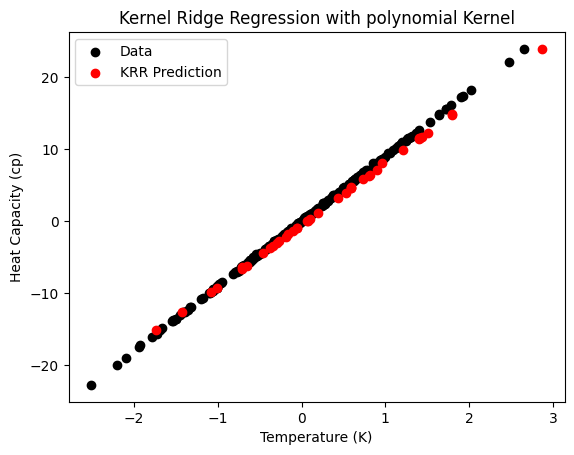

In [199]:
# Kernel model to reproduce the heat capacity 12C2

# Load the data
data = pd.read_csv("12C2__8states.cp", names=["T", "cp"], header=None, sep='\s+')

# Define features: Temperature and target is heat capacity
X = data['T'].values
y = data['cp'].values

# Train-test split
X, y = make_regression(n_samples=200, n_features=1, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
krr = KernelRidge(kernel='poly', alpha=0.1, gamma=1.0)
krr.fit(X_train, y_train)

# Predict and evaluate
y_pred = krr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f} eV')
print(f'R² Score: {r2:.4f}')

# Found the best parameters to have the expectred accuracy
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0],
}
grid_search = GridSearchCV(KernelRidge(kernel='poly'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

plt.scatter(X, y, color='black', label='Data')
plt.scatter(X_test, y_test, color='red', label='KRR Prediction')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity (cp)')
plt.legend()
plt.title('Kernel Ridge Regression with polynomial Kernel')
plt.show()

Mean Squared Error: 0.01 eV
R² Score: 1.0000
Best parameters found: {'alpha': 0.1, 'gamma': 1.0}


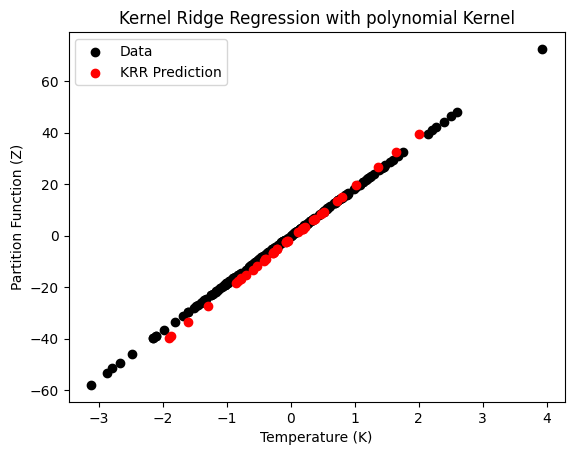

In [200]:
# Kernel model to reproduce the partition function of 12C2

# Load the data
data = pd.read_csv("12C2__8states.pf", names=["T", "pf"], header=None, sep='\s+')

# Define features: Temperature and target is heat capacity
X = data['T'].values
y = data['pf'].values

# Train-test split
X, y = make_regression(n_samples=200, n_features=1, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
krr = KernelRidge(kernel='poly', alpha=0.1, gamma=1.0)
krr.fit(X_train, y_train)

# Predict and evaluate
y_pred = krr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f} eV')
print(f'R² Score: {r2:.4f}')

# Found the best parameters to have the expectred accuracy
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0],
}
grid_search = GridSearchCV(KernelRidge(kernel='poly'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)

plt.scatter(X, y, color='black', label='Data')
plt.scatter(X_test, y_test, color='red', label='KRR Prediction')
plt.xlabel('Temperature (K)')
plt.ylabel('Partition Function (Z)')
plt.legend()
plt.title('Kernel Ridge Regression with polynomial Kernel')
plt.show()